# Introduction

For starters we will use ten different actors, denoted by different video id:s.


We will apply LOGO CV (Leave One Group Out cross-validation)

We will later have to take into account variables like mode (prosody or vocalization) and intensity (1-4) in the cross validation scheme. 

However for the first run it will be fine to include all without taking such factors into account.



In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import scipy
from dotenv import load_dotenv

# Working dir

In [4]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from src.sql_handling.execute_sql import execute_sql_pandas

# Paths

In [6]:
load_dotenv()

# path to save figures
output_path = os.getenv("VIDEO_OUT")

# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [7]:
exec(open(glob_conf_path).read())

# Select data from DB

We only select data that satisfies following three conditions:

* Success == 1
* Confidence rate >= 0.98
* mix (mixed emotions) = False(0)

We also only select the following six video_ids: 'A101', 'A102', 'A18', 'A200'

In [8]:
query = """SELECT filename,
video_id,
emotion_1,
emotion_1_id,
AU01_r,
AU02_r,
AU04_r,
AU05_r,
AU06_r,
AU07_r,
AU09_r,
AU10_r,
AU12_r,
AU14_r,
AU15_r,
AU17_r,
AU20_r,
AU23_r,
AU25_r,
AU26_r,
AU45_r
FROM openface
WHERE success = 1 AND confidence >= 0.98 AND mix = 0
AND video_id IN ('A101', 'A102', 'A18', 'A200');"""
df, read_duration = execute_sql_pandas(query)

In [9]:
print("query executed in: {} seconds".format(read_duration))

query executed in: 45.541 seconds


In [10]:
df

,filename,video_id,emotion_1,emotion_1_id,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A102_ten_p_2,A102,ten,28,0.71,0.00,0.0,0.00,0.72,0.04,...,1.02,2.21,0.46,0.00,0.23,0.00,0.0,1.48,0.00,0.0
1,A102_ten_p_2,A102,ten,28,0.68,0.00,0.0,0.00,0.69,0.01,...,1.09,2.18,0.50,0.00,0.22,0.00,0.0,1.50,0.00,0.0
2,A102_ten_p_2,A102,ten,28,0.66,0.00,0.0,0.00,0.64,0.00,...,1.12,2.14,0.48,0.00,0.16,0.00,0.0,1.57,0.00,0.0
3,A102_ten_p_2,A102,ten,28,0.63,0.00,0.0,0.00,0.65,0.00,...,1.12,2.10,0.49,0.00,0.07,0.00,0.0,1.62,0.00,0.0
4,A102_ten_p_2,A102,ten,28,0.55,0.00,0.0,0.00,0.64,0.01,...,1.09,2.05,0.44,0.00,0.02,0.00,0.0,1.73,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300094,A200_sar_v_3,A200,sar,31,1.63,0.36,0.0,0.16,0.00,0.02,...,0.00,1.40,1.68,0.23,0.97,0.06,0.0,0.00,0.35,0.0
300095,A200_sar_v_3,A200,sar,31,1.68,0.28,0.0,0.09,0.01,0.16,...,0.05,1.43,1.64,0.30,1.04,0.00,0.0,0.00,0.22,0.0
300096,A200_sar_v_3,A200,sar,31,1.56,0.23,0.0,0.06,0.02,0.16,...,0.05,1.43,1.55,0.39,1.05,0.03,0.0,0.00,0.20,0.0
300097,A200_sar_v_3,A200,sar,31,1.41,0.13,0.0,0.00,0.08,0.18,...,0.05,1.47,1.62,0.38,0.98,0.03,0.0,0.00,0.19,0.0


Total number of instances: 300099

Number of Instances per File (before data cleaning)
A101_neu_sit1_v    800
A102_mov_v_4       681
A102_sad_v_4       644
A200_conc_p_4      608
A102_reg_v_4       598
                  ... 
A200_det_p_1        64
A18_sha_v_2         62
A200_rej_p_4        51
A200_hop_p_1        47
A200_adm_p_1        43
Name: filename, Length: 1396, dtype: int64



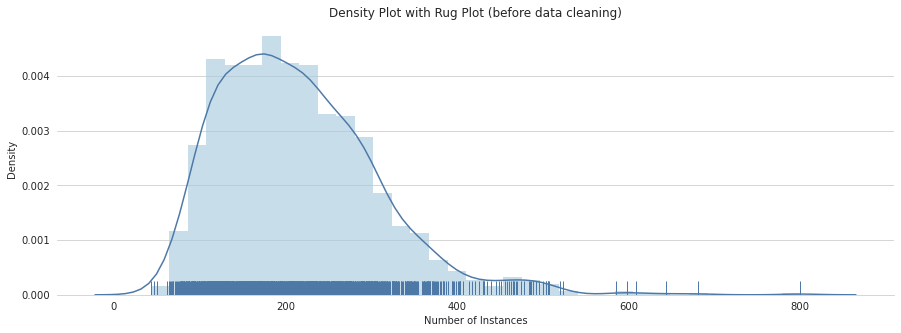


Number of Instances per Video id (before data cleaning)
A102    104284
A101     79724
A200     62858
A18      53233
Name: video_id, dtype: int64


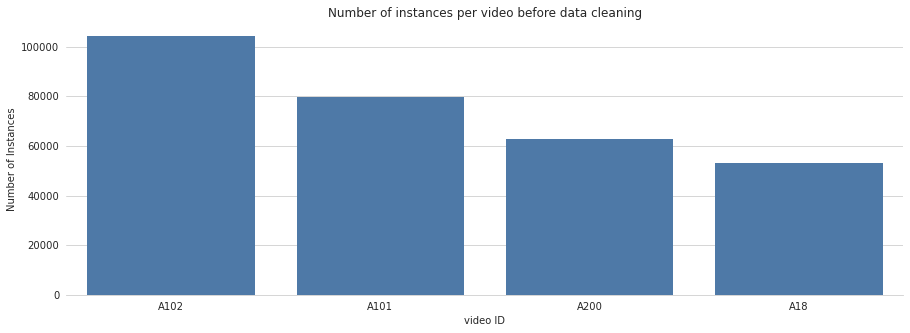


Number of Instances per Emotion (before data cleaning)
sad        9032
neu        8168
gui        7953
fea        7864
reg        7742
conc       7640
disa       7609
sha        7563
awe        7563
dou        7548
emb        7519
env        7224
nos        7175
anx        7166
pea        7084
hop        7034
bor        7006
exc        7003
conf       6974
neg_sur    6917
ang        6852
mov        6836
cont       6817
ins        6772
disg       6732
rej        6668
ele        6638
scha       6603
rel        6570
amu        6567
hap        6462
ple        6396
pri        6389
sat        6142
dist       6107
int        5990
sex        5889
ten        5852
pos_sur    5835
adm        5769
det        5669
tri        5656
sar        5639
gra        5465
Name: emotion_1, dtype: int64


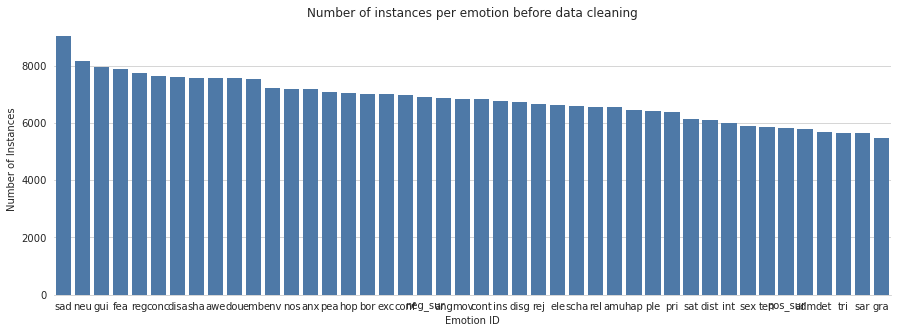

In [11]:
print("Total number of instances: {}".format(len(df)))
print()


print("Number of Instances per File (before data cleaning)")
file_val_counts_original = df["filename"].value_counts()
print(file_val_counts_original)
print()


x = file_val_counts_original.values
plt.figure(figsize=(15,5))
sns.distplot(x, rug=True, norm_hist=True,
             rug_kws={'color': blue_shades[0],'alpha':1},
             kde_kws={'color': blue_shades[0],'alpha':1},
             hist_kws={'color': blue_shades[1], 'alpha':0.6}
            )
plt.xlabel('Number of Instances')
plt.ylabel('Density')
plt.grid(False,axis='x')
plt.savefig(os.path.join(output_path,'charts','report_distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.title('Density Plot with Rug Plot (before data cleaning)')
plt.savefig(os.path.join(output_path,'charts','distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Number of Instances per Video id (before data cleaning)")
video_val_counts_original = df["video_id"].value_counts()
print(video_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(video_val_counts_original.index, video_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per video before data cleaning")
plt.xlabel('video ID')
plt.ylabel('Number of Instances')
plt.show()
print()


print("Number of Instances per Emotion (before data cleaning)")
emotion_val_counts_original = df["emotion_1"].value_counts()
print(emotion_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(emotion_val_counts_original.index, emotion_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per emotion before data cleaning")
plt.xlabel('Emotion ID')
plt.ylabel('Number of Instances')
#plt.xticks(rotation=45)
plt.show()
print()

Lets see how many files we have per video id

In [12]:
print("Number of Instances per video id for every filename")
video_val_counts_original = df[['video_id','filename']].groupby(["video_id"]).filename.nunique().reset_index()
print(video_val_counts_original)
print()

Number of Instances per video id for every filename
  video_id  filename
0     A101       352
1     A102       352
2      A18       352
3     A200       340



# From time series data to average features

In [13]:
from scipy.signal import find_peaks

def my_find_peaks(x):
    """
    This function takes a 1-D array and finds all local maxima by simple comparison of neighboring values. 
    Optionally, a subset of these peaks can be selected by specifying conditions for a peak’s properties.
    """
    th = x.mean()
    val = x.values
    peaks, _ = find_peaks(val, height=th)
    return len(peaks)

In [14]:
df_tmp = df.drop(columns=["video_id", "emotion_1", "emotion_1_id"])

# Compute statistical measures 
df_tmp = df_tmp.groupby(['filename']).agg(['mean',                                    # Arithmetic mean
                                          lambda x: scipy.stats.variation(x),        # Coefficient of variation
                                          lambda x: np.percentile(x, q=20),          # 20th percentile, i.e. below this value 20% of the observations will be found
                                          lambda x: np.percentile(x, q=50),          # 50th percentile, i.e. below this value 50% of the observations will be found
                                          lambda x: np.percentile(x, q=80),          # 80th percentile, i.e. below this value 80% of the observations will be found
                                          lambda x: scipy.stats.iqr(x, rng=(20,80)), # IQR(60%) = 80th percentile - 20th percentile
                                          lambda x: my_find_peaks(x),                # Number of peaks above the adaptive threshold
                                          ]).reset_index().sort_values(by=['filename'], ignore_index=True)

# Rename columns
df_tmp.rename(columns={'<lambda_0>': 'stddevNorm',
                       '<lambda_1>': 'percentile20.0',
                       '<lambda_2>': 'percentile50.0',
                       '<lambda_3>': 'percentile80.0',
                       '<lambda_4>': 'iqr60_80-20',
                       '<lambda_5>': 'numPeaks',
                      }, level=1,inplace=True)

# Impute NaN values
# There might be some NaN values in the dataframe coming from the coefficient of variation (std(x)/mean(x) when mean(x)=0) 
df_tmp.fillna(0, inplace=True)

# Collapse hierarchical index in columns
df_tmp.columns = ['_'.join(col).strip('_') for col in df_tmp.columns.values]

# check for null values
df_tmp.isnull().values.any()

/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)
/home/tim/anaconda3/envs/thesi

False

In [15]:
df_tmp

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU26_r_percentile80.0,AU26_r_iqr60_80-20,AU26_r_numPeaks,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks
0,A101_adm_p_1,0.130881,1.512253,0.0,0.010,0.314,0.314,13,0.055723,1.963130,...,0.644,0.644,11,0.196289,2.594698,0.0,0.000,0.184,0.184,5
1,A101_adm_p_2,0.093125,1.530822,0.0,0.010,0.232,0.232,10,0.048688,1.904601,...,0.804,0.794,8,0.067438,1.602173,0.0,0.030,0.122,0.122,12
2,A101_adm_p_3,0.137134,1.369730,0.0,0.000,0.320,0.320,20,0.039186,1.909761,...,0.898,0.898,27,0.407948,2.247741,0.0,0.000,0.408,0.408,8
3,A101_adm_p_4,0.179773,1.672593,0.0,0.010,0.310,0.310,9,0.121648,2.191445,...,0.990,0.990,7,0.397784,2.554866,0.0,0.005,0.270,0.270,2
4,A101_adm_v_1,0.045781,1.371347,0.0,0.000,0.100,0.100,8,0.063828,1.870961,...,0.200,0.200,16,0.119141,1.708587,0.0,0.020,0.180,0.180,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,A200_tri_p_4,0.289699,1.403708,0.0,0.030,0.728,0.728,8,0.079850,1.978715,...,1.572,1.572,8,0.118120,1.459277,0.0,0.030,0.230,0.230,11
1392,A200_tri_v_1,0.311200,1.351740,0.0,0.000,0.682,0.682,7,0.085440,2.211082,...,1.628,1.628,6,0.229600,2.097769,0.0,0.000,0.250,0.250,5
1393,A200_tri_v_2,0.095472,1.369401,0.0,0.015,0.210,0.210,6,0.076321,1.788978,...,2.180,2.170,10,0.089434,1.227926,0.0,0.025,0.200,0.200,10
1394,A200_tri_v_3,0.339846,1.592973,0.0,0.000,0.722,0.722,4,0.056615,1.961320,...,2.100,2.100,9,0.252077,1.741491,0.0,0.000,0.454,0.454,6


# Normalize training set

Merge on filename index... Merge with metadata afterwards...

A way to normalize the input features/variables is the Min-Max scaler. By doing so, all features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.

In [16]:
from sklearn import preprocessing

# create a separate dataframe to keep track of index
df_filename = df_tmp[["filename"]]

# get only features
X = df_tmp.drop(columns=['filename'])

min_max_scaler = preprocessing.MinMaxScaler()

# Fit and transform features
X_scaled = min_max_scaler.fit_transform(X)

# Create a dataframe from normalized features
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())

# join back on index with filename dataframe
X_scaled_df = df_filename.join(X_scaled_df)

In [17]:
X_scaled_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU26_r_percentile80.0,AU26_r_iqr60_80-20,AU26_r_numPeaks,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks
0,A101_adm_p_1,0.083291,0.381802,0.0,0.166667,0.064548,0.064548,0.236364,0.077383,0.310913,...,0.171906,0.177409,0.150000,0.110677,0.708362,0.0,0.000000,0.026531,0.026531,0.10
1,A101_adm_p_2,0.053272,0.391230,0.0,0.166667,0.044499,0.044499,0.181818,0.061739,0.286762,...,0.225418,0.227243,0.100000,0.016793,0.306634,0.0,0.428571,0.010714,0.010714,0.24
2,A101_adm_p_3,0.088263,0.309445,0.0,0.000000,0.066015,0.066015,0.363636,0.040611,0.288891,...,0.256856,0.261794,0.416667,0.264896,0.567930,0.0,0.000000,0.083673,0.083673,0.16
3,A101_adm_p_4,0.122165,0.463205,0.0,0.166667,0.063570,0.063570,0.163636,0.223966,0.405124,...,0.287625,0.292359,0.083333,0.257490,0.692240,0.0,0.071429,0.048469,0.048469,0.04
4,A101_adm_v_1,0.015630,0.310266,0.0,0.000000,0.012225,0.012225,0.145455,0.095404,0.272881,...,0.023411,0.029900,0.233333,0.054465,0.349705,0.0,0.285714,0.025510,0.025510,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,A200_tri_p_4,0.209567,0.326696,0.0,0.500000,0.165770,0.165770,0.145455,0.131028,0.317344,...,0.482274,0.485714,0.100000,0.053721,0.248796,0.0,0.428571,0.038265,0.038265,0.22
1392,A200_tri_v_1,0.226662,0.300312,0.0,0.000000,0.154523,0.154523,0.127273,0.143458,0.413227,...,0.501003,0.504319,0.066667,0.134948,0.507228,0.0,0.000000,0.043367,0.043367,0.10
1393,A200_tri_v_2,0.055138,0.309278,0.0,0.250000,0.039120,0.039120,0.109091,0.123181,0.239052,...,0.685619,0.684385,0.133333,0.032820,0.155156,0.0,0.357143,0.030612,0.030612,0.20
1394,A200_tri_v_3,0.249438,0.422783,0.0,0.000000,0.164303,0.164303,0.072727,0.079366,0.310166,...,0.658863,0.661130,0.116667,0.151325,0.363023,0.0,0.000000,0.095408,0.095408,0.12


In [18]:
# get the metadata from original dataframe
df_metadata = df[["filename", "video_id", "emotion_1_id"]]

# drop all duplicate rows, will collapse dataframe to unique filenames
df_metadata = df_metadata.drop_duplicates()

# merge metadata with temporary dataframe
train_scaled_df = pd.merge(X_scaled_df, df_metadata, on="filename")

In [19]:
train_scaled_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU26_r_numPeaks,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,video_id,emotion_1_id
0,A101_adm_p_1,0.083291,0.381802,0.0,0.166667,0.064548,0.064548,0.236364,0.077383,0.310913,...,0.150000,0.110677,0.708362,0.0,0.000000,0.026531,0.026531,0.10,A101,5
1,A101_adm_p_2,0.053272,0.391230,0.0,0.166667,0.044499,0.044499,0.181818,0.061739,0.286762,...,0.100000,0.016793,0.306634,0.0,0.428571,0.010714,0.010714,0.24,A101,5
2,A101_adm_p_3,0.088263,0.309445,0.0,0.000000,0.066015,0.066015,0.363636,0.040611,0.288891,...,0.416667,0.264896,0.567930,0.0,0.000000,0.083673,0.083673,0.16,A101,5
3,A101_adm_p_4,0.122165,0.463205,0.0,0.166667,0.063570,0.063570,0.163636,0.223966,0.405124,...,0.083333,0.257490,0.692240,0.0,0.071429,0.048469,0.048469,0.04,A101,5
4,A101_adm_v_1,0.015630,0.310266,0.0,0.000000,0.012225,0.012225,0.145455,0.095404,0.272881,...,0.233333,0.054465,0.349705,0.0,0.285714,0.025510,0.025510,0.10,A101,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,A200_tri_p_4,0.209567,0.326696,0.0,0.500000,0.165770,0.165770,0.145455,0.131028,0.317344,...,0.100000,0.053721,0.248796,0.0,0.428571,0.038265,0.038265,0.22,A200,20
1392,A200_tri_v_1,0.226662,0.300312,0.0,0.000000,0.154523,0.154523,0.127273,0.143458,0.413227,...,0.066667,0.134948,0.507228,0.0,0.000000,0.043367,0.043367,0.10,A200,20
1393,A200_tri_v_2,0.055138,0.309278,0.0,0.250000,0.039120,0.039120,0.109091,0.123181,0.239052,...,0.133333,0.032820,0.155156,0.0,0.357143,0.030612,0.030612,0.20,A200,20
1394,A200_tri_v_3,0.249438,0.422783,0.0,0.000000,0.164303,0.164303,0.072727,0.079366,0.310166,...,0.116667,0.151325,0.363023,0.0,0.000000,0.095408,0.095408,0.12,A200,20


# Create groups for LOGO CV

We will apply LOGO CV (Leave One Group Out cross-validation)

In [20]:
train_scaled_df.video_id.unique()

array(['A101', 'A102', 'A18', 'A200'], dtype=object)

In [21]:
def get_evens(size):
    ret = []
    for n in range(size):
        if n % 2 == 0:
            ret.append(n)
    return ret

def get_odds(size):
    ret = []
    for n in range(size):
        if n % 2 == 1:
            ret.append(n)
    return ret

In [22]:
import random

video_ids = train_scaled_df.video_id.unique()

# Find random pairs of video_ids
random.seed(seed)

# a list of even numbers
video_ids_1 = get_evens(len(video_ids))

# a list of odd numbers
video_ids_2 = get_odds(len(video_ids))

# shuffle the odd numbers
video_ids_2_shuffled = random.sample(video_ids_2, len(video_ids_2))

# assign groups for video ids by using odd and even numbers respectively
groups = {}
for i, video_id in enumerate(video_ids_1):
    groups[video_ids[video_id]] = i
    
for i, video_id in enumerate(video_ids_2_shuffled):
    groups[video_ids[video_id]] = i
    
print(groups)

# Create a copy
train_scaled_groups_df = train_scaled_df.copy()

# Insert group column
train_scaled_groups_df['group'] = train_scaled_groups_df['video_id'].map(groups)

{'A101': 0, 'A18': 1, 'A200': 0, 'A102': 1}


In [23]:
train_scaled_groups_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,video_id,emotion_1_id,group
0,A101_adm_p_1,0.083291,0.381802,0.0,0.166667,0.064548,0.064548,0.236364,0.077383,0.310913,...,0.110677,0.708362,0.0,0.000000,0.026531,0.026531,0.10,A101,5,0
1,A101_adm_p_2,0.053272,0.391230,0.0,0.166667,0.044499,0.044499,0.181818,0.061739,0.286762,...,0.016793,0.306634,0.0,0.428571,0.010714,0.010714,0.24,A101,5,0
2,A101_adm_p_3,0.088263,0.309445,0.0,0.000000,0.066015,0.066015,0.363636,0.040611,0.288891,...,0.264896,0.567930,0.0,0.000000,0.083673,0.083673,0.16,A101,5,0
3,A101_adm_p_4,0.122165,0.463205,0.0,0.166667,0.063570,0.063570,0.163636,0.223966,0.405124,...,0.257490,0.692240,0.0,0.071429,0.048469,0.048469,0.04,A101,5,0
4,A101_adm_v_1,0.015630,0.310266,0.0,0.000000,0.012225,0.012225,0.145455,0.095404,0.272881,...,0.054465,0.349705,0.0,0.285714,0.025510,0.025510,0.10,A101,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,A200_tri_p_4,0.209567,0.326696,0.0,0.500000,0.165770,0.165770,0.145455,0.131028,0.317344,...,0.053721,0.248796,0.0,0.428571,0.038265,0.038265,0.22,A200,20,0
1392,A200_tri_v_1,0.226662,0.300312,0.0,0.000000,0.154523,0.154523,0.127273,0.143458,0.413227,...,0.134948,0.507228,0.0,0.000000,0.043367,0.043367,0.10,A200,20,0
1393,A200_tri_v_2,0.055138,0.309278,0.0,0.250000,0.039120,0.039120,0.109091,0.123181,0.239052,...,0.032820,0.155156,0.0,0.357143,0.030612,0.030612,0.20,A200,20,0
1394,A200_tri_v_3,0.249438,0.422783,0.0,0.000000,0.164303,0.164303,0.072727,0.079366,0.310166,...,0.151325,0.363023,0.0,0.000000,0.095408,0.095408,0.12,A200,20,0


In [24]:
save_path = os.path.join(output_path, 'video_data_intensity_train.csv')
train_scaled_groups_df.to_csv(save_path, index=None, header=True)